# Importing Required Libraries  
This cell imports necessary libraries for image processing, feature extraction (HOG, LBP), machine learning (SVM, MLP), and evaluation metrics.  


In [1]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report


# Loading and Preprocessing the Dataset  
This section loads images of faces with and without masks, converts them to grayscale, resizes them to 64x64 pixels, and assigns labels (1 for mask, 0 for no mask). The dataset is then split into training and testing sets.  


In [2]:
# Set paths
mask_path = "../dataset_my/Face-Mask-Detection/dataset/with_mask"
no_mask_path = "../dataset_my/Face-Mask-Detection/dataset/without_mask"

# Function to load images
def load_images(folder, label):
    images = []
    labels = []
    for file in glob.glob(folder + "/*.jpg"):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        img = cv2.resize(img, (64, 64))  # Resize
        images.append(img)
        labels.append(label)
    return images, labels

# Load dataset
mask_images, mask_labels = load_images(mask_path, 1)  # 1 = Mask
no_mask_images, no_mask_labels = load_images(no_mask_path, 0)  # 0 = No Mask

# Combine dataset
X = np.array(mask_images + no_mask_images)
y = np.array(mask_labels + no_mask_labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset loaded: {len(X_train)} training images, {len(X_test)} testing images")


Dataset loaded: 3012 training images, 753 testing images


In [3]:
# Function to extract HOG and LBP features
def extract_features(images):
    features = []
    for img in images:
        # HOG Features
        hog_feat = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        
        # LBP Features
        lbp = local_binary_pattern(img, P=8, R=1, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), density=True)
        
        # Combine features
        combined_feat = np.hstack((hog_feat, lbp_hist))
        features.append(combined_feat)
    
    return np.array(features)

# Extract features for train and test sets
X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)

# Standardize features
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = scaler.transform(X_test_features)

print("Feature extraction complete!")


Feature extraction complete!


### Training and Evaluating the SVM Classifier  
An SVM model with a linear kernel is trained on the extracted features. After training, predictions are made on the test set, and the model's performance is evaluated using classification metrics and accuracy.  


In [4]:
# Train SVM classifier
svm_model = SVC(kernel="linear", C=1.0)
svm_model.fit(X_train_features, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test_features)

# Performance
print("SVM Classifier Performance:")
print(classification_report(y_test, y_pred_svm))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))


SVM Classifier Performance:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       374
           1       0.87      0.89      0.88       379

    accuracy                           0.88       753
   macro avg       0.88      0.88      0.88       753
weighted avg       0.88      0.88      0.88       753

SVM Accuracy: 0.8804780876494024


### Training and Evaluating the MLP Classifier  
An MLP (Multi-Layer Perceptron) neural network with one hidden layer of 100 neurons is trained using the ReLU activation function and Adam optimizer. The model's performance is evaluated using classification metrics and accuracy.  


In [5]:
# Train MLP Classifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation="relu", solver="adam", max_iter=500)
mlp_model.fit(X_train_features, y_train)

# Predictions
y_pred_mlp = mlp_model.predict(X_test_features)

# Performance
print("MLP Classifier Performance:")
print(classification_report(y_test, y_pred_mlp))
print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))


MLP Classifier Performance:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       374
           1       0.92      0.94      0.93       379

    accuracy                           0.93       753
   macro avg       0.93      0.93      0.93       753
weighted avg       0.93      0.93      0.93       753

MLP Accuracy: 0.9256308100929614


Part B
### Importing Libraries for CNN Model  
This cell imports TensorFlow and Keras components required to build and train a CNN model. It also includes utilities for image preprocessing, optimization, and performance evaluation.  


In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import os


In [28]:
# import osnotebooks

# dataset_path = "../dataset_my/Face-Mask-Detection/dataset"  # Update path if needed

# # Check dataset contents
# print(os.listdir(dataset_path))


### Loading and Preprocessing Images for CNN  
This section loads images from the dataset, ensuring they are valid and properly formatted. Images are resized to 64x64 pixels, normalized, and split into training and testing sets. Non-image files and corrupted images are skipped to maintain data integrity.  


In [29]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split

# Define dataset path
dataset_path = "../dataset_my/Face-Mask-Detection/dataset"  # Adjust if needed
categories = ["with_mask", "without_mask"]  # Class labels

# Initialize lists for images and labels
X, y = [], []

# Define valid image extensions
valid_extensions = ('.jpg', '.jpeg', '.png')

# Load images
for label, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)

    if not os.path.exists(category_path):
        print(f"Error: Path does not exist - {category_path}")
        continue

    for img_name in os.listdir(category_path):
        if not img_name.lower().endswith(valid_extensions):
            print(f"Skipping non-image file: {img_name}")
            continue  # Skip non-image files

        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)

        if img is None:  # Check if image is loaded correctly
            print(f"Skipping corrupted/missing image: {img_path}")
            continue  # Skip this image

        img = cv2.resize(img, (64, 64))  # Resize to match CNN input
        X.append(img)
        y.append(label)

# Convert to NumPy arrays
if len(X) == 0:
    raise ValueError("No valid images found in the dataset. Check dataset path and file formats.")

X = np.array(X, dtype=np.float32) / 255.0  # Normalize pixel values
y = np.array(y)

# Split dataset into training and testing sets
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {train_X.shape}, Labels: {train_Y.shape}")
print(f"Testing set: {test_X.shape}, Labels: {test_Y.shape}")


Skipping corrupted/missing image: ../dataset_my/Face-Mask-Detection/dataset\with_mask\0_0_œ¬‘ÿ.png
Skipping corrupted/missing image: ../dataset_my/Face-Mask-Detection/dataset\with_mask\0_0_≈˙◊¢ 2020-02-23 132115.png
Skipping corrupted/missing image: ../dataset_my/Face-Mask-Detection/dataset\with_mask\0_0_≈˙◊¢ 2020-02-23 132400.png
Skipping corrupted/missing image: ../dataset_my/Face-Mask-Detection/dataset\with_mask\0_0_≈˙◊¢ 2020-02-24 171804.png
Skipping corrupted/missing image: ../dataset_my/Face-Mask-Detection/dataset\with_mask\0_0_≈˙◊¢ 2020-02-24 172039.png
Skipping corrupted/missing image: ../dataset_my/Face-Mask-Detection/dataset\with_mask\0_0_≈˙◊¢ 2020-02-24 202509.png
Skipping corrupted/missing image: ../dataset_my/Face-Mask-Detection/dataset\with_mask\0_0_≈˙◊¢ 2020-02-24 205216.png
Skipping corrupted/missing image: ../dataset_my/Face-Mask-Detection/dataset\with_mask\0_0_≈˙◊¢ 2020-02-24 215234.png
Skipping corrupted/missing image: ../dataset_my/Face-Mask-Detection/dataset\with_m

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = model.fit(
    train_X, train_Y, 
    validation_data=(test_X, test_Y), 
    epochs=50, 
    batch_size=32  # Reduce from 32 to 16 or even 8
)


Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7656 - loss: 0.4554 - val_accuracy: 0.9140 - val_loss: 0.2325
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9396 - loss: 0.1625 - val_accuracy: 0.9263 - val_loss: 0.2090
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9519 - loss: 0.1427 - val_accuracy: 0.9447 - val_loss: 0.1689
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9682 - loss: 0.0977 - val_accuracy: 0.9435 - val_loss: 0.1868
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9790 - loss: 0.0673 - val_accuracy: 0.9300 - val_loss: 0.2302
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9817 - loss: 0.0692 - val_accuracy: 0.9545 - val_loss: 0.1461
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9838 - loss: 0.0431 - val_accuracy: 0.9496 - val_loss: 0.1787
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9845 - loss: 0.0508 - val_accu

In [32]:
test_loss, test_acc = model.evaluate(test_X, test_Y, verbose=2)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')


26/26 - 0s - 11ms/step - accuracy: 0.9631 - loss: 0.3275
Test Accuracy: 0.9631
Test Loss: 0.3275


### Visualizing Model Performance  
This section plots the training and validation accuracy/loss over epochs to analyze the model's learning progress and detect potential overfitting or underfitting.  


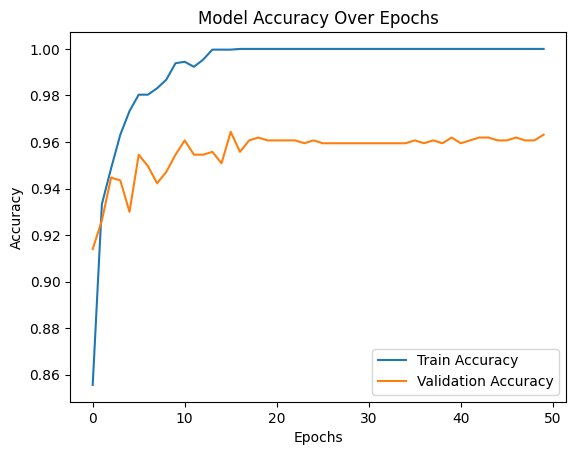

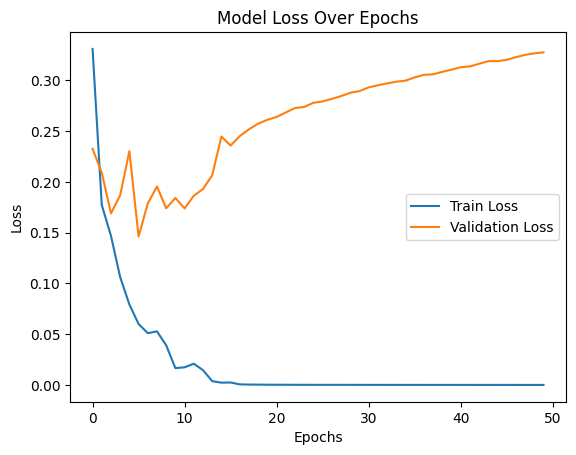

In [33]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Over Epochs')
plt.show()


In [34]:
from sklearn.metrics import classification_report

# Predict labels on the test set
y_pred = model.predict(test_X)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

# Print classification report
print(classification_report(test_Y, y_pred, target_names=["With Mask", "Without Mask"]))


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

   With Mask       0.97      0.96      0.97       438
Without Mask       0.96      0.96      0.96       376

    accuracy                           0.96       814
   macro avg       0.96      0.96      0.96       814
weighted avg       0.96      0.96      0.96       814



In [35]:
print(f'Final Test Accuracy: {test_acc:.4f}')

Final Test Accuracy: 0.9631
